<H3>Creating the Data Frame using the URL link!!<H3>

In [2]:
#required imports for the project!!
import numpy as np 
import pandas as pd

import json # library to handle JSON files
 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
    
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
#code to get the postal data from URL into data frame.
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
url_data = pd.read_html(url)
postal_data = pd.DataFrame(url_data[0])
print('DataFrame created with the URL data!!')

DataFrame created with the URL data!!


In [4]:
#code to drop the entries with Borough == 'Not assigned'
drop_index = postal_data[postal_data['Borough']=='Not assigned'].index
print('Row count before dropping {}.'.format(len(postal_data)))
postal_data.drop(drop_index,inplace=True)
print('------------------------------------------------------------------------')
print('Dropped {} rows from the initial data collection'.format(len(drop_index)))
print('Row count after dropping {}.'.format(len(postal_data)))

Row count before dropping 287.
------------------------------------------------------------------------
Dropped 77 rows from the initial data collection
Row count after dropping 210.


In [5]:
#code to combine rows with same postal code
postal_data = postal_data.groupby(['Postcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
print('Row count after combining {}.'.format(len(postal_data)))

Row count after combining 103.


In [6]:
#code to set the Neighborhood for 'Not assinged' values to Borough
copy_index = postal_data.loc[postal_data['Neighborhood'] == 'Not assigned'].index
print('Number of records with Neighborhood not assigned {} '.format(len(copy_index)))
postal_data['Neighborhood'].loc[copy_index] = postal_data['Borough'].loc[copy_index]

Number of records with Neighborhood not assigned 1 


In [7]:
#shape of the data 
print('Shape of the postal data {}'.format(postal_data.shape))
postal_data

Shape of the postal data (103, 3)


,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


<H3>Adding latitude and longitude values for the postal data<H3>

In [8]:
#The csv file was downloaded to local folder before creating the final data frame!!
#creating data frame for the csv file!!
geolocation = pd.read_csv('geo.csv',index_col=0)

In [9]:
#adding latitute and longitute
lat = []
long = []
for postcode in postal_data['Postcode']:
    lat.append(float(geolocation['Latitude'].loc[geolocation['Postal Code'] == postcode]))
    long.append(float(geolocation['Longitude'].loc[geolocation['Postal Code'] == postcode]))
postal_data['Latitude'] = lat
postal_data['Longitude'] = long
postal_data

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


<H3>Clustering the neighborhood in Toronto!!<H3>

In [10]:
#code to get the data frame for Toronto!!
index = []
i = 0
for Borough in postal_data['Borough']:
    if ('Toronto' in Borough):
        index.append(i)
    i += 1
toronto_data = postal_data.loc[index].reset_index(drop=True)
toronto_data.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [11]:
#geolocation of Toronto, ON
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [12]:
#creating map of Toronto!!
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lati, lngi, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [1]:
#foursquare credentials
CLIENT_ID = 'B1TIJO5AFFZF4Y4BL4OUTN1VMWAFZGVN2JF2YOKOZQTXEOJA' # your Foursquare ID
CLIENT_SECRET = 'UPCL15AJXRZEIHKX20PHXAHZQFY0D2352GE5KCGBU2LHTISY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B1TIJO5AFFZF4Y4BL4OUTN1VMWAFZGVN2JF2YOKOZQTXEOJA
CLIENT_SECRET:UPCL15AJXRZEIHKX20PHXAHZQFY0D2352GE5KCGBU2LHTISY


In [13]:
#function to get foursquare data for all the neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
#get the required data 
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )


In [15]:
#data frame containing the toronto venus data!!
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [16]:
#analysing each Neighborhood
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#grouping all neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,"Adelaide, King, Richmond",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.02,...,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.01,0.0
1,Berczy Park,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.00,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0


In [18]:
#printing each neighborhood with top 5 venus
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.08
1              Café  0.05
2        Steakhouse  0.04
3               Bar  0.04
4  Sushi Restaurant  0.03


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2      Farmers Market  0.04
3  Seafood Restaurant  0.04
4         Cheese Shop  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0            Café  0.14
1  Breakfast Spot  0.10
2     Coffee Shop  0.10
3    Climbing Gym  0.05
4    Intersection  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.12
1          Restaurant  0.06
2       Auto Workshop  0.06
3          Smoke Shop  0.06
4          Skate Park  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12

In [19]:
#function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
#data frame with top 10 venus of each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Asian Restaurant,Burger Joint,Thai Restaurant,Restaurant,Sushi Restaurant,Salad Place
1,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Beer Bar,Steakhouse,Seafood Restaurant,Farmers Market,Cheese Shop,Café,Park
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Gym,Bakery,Performing Arts Venue,Pet Store,Grocery Store,Climbing Gym,Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Brewery,Recording Studio,Restaurant,Burrito Place,Auto Workshop,Fast Food Restaurant,Spa,Farmers Market,Garden Center
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Coffee Shop,Plane,Rental Car Location,Sculpture Garden,Boat or Ferry,Harbor / Marina,Airport Food Court


In [37]:
#clustering neighborhood
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

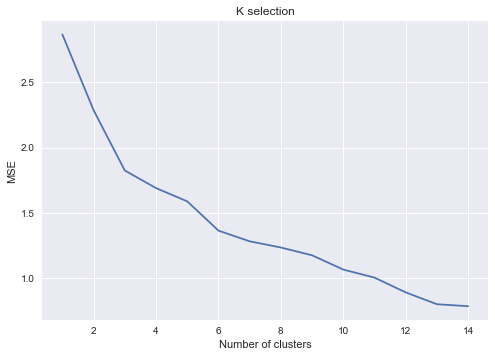

In [23]:
# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

plt.style.use("seaborn")
Ks = 15
mse = np.zeros((Ks-1))
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(toronto_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()


In [38]:
#adding labels
neighborhoods_venues_sorted.drop('Cluster Labels',1,inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.0,Health Food Store,Other Great Outdoors,Trail,Pub,Wings Joint,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1.0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Restaurant,Bubble Tea Shop,Indian Restaurant,Spa
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1.0,Park,Pizza Place,Pet Store,Pub,Brewery,Sandwich Place,Burger Joint,Burrito Place,Fast Food Restaurant,Italian Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1.0,Café,Coffee Shop,Bakery,Gastropub,Italian Restaurant,American Restaurant,Convenience Store,Sandwich Place,Brewery,Cheese Shop
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4.0,Photography Studio,Park,Bus Line,Swim School,Dim Sum Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [40]:
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

In [41]:
#creating the map!!
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters